# Analysis on correlation between earthquakes and surface mass loading in spherical caps

In [32]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma
from tqdm import tqdm
from shapely.geometry import Polygon

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

In [2]:
# import sys
# !{sys.executable} -m pip install netcdf4

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [3]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")

In [4]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

In [5]:
depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [6]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [7]:
etas_declustered = pd.read_csv('etas_declustered.csv')
catalog = pd.read_csv('catalog.csv')

## 4. Analyze correlation between all events and surface mass loading by mascon

###  This method calculates LgE and L by mascon.

## New methodology

In [14]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Convert catalog to GeoDataFrame
geometry = [Point(xy) for xy in zip(catalog['longitude'], catalog['latitude'])]
catalog_gdf = gpd.GeoDataFrame(catalog, geometry=geometry, crs="EPSG:4326")# Handle the earthquakes by "mascon"

In [15]:
def get_cp(LgE, L, method):
    cp_list = []  
    
#     bins = loadquakes.calculate_bin_sizes(LgE, method)
    bins = np.linspace(-20,20,20)

    LgE_hist = np.histogram(LgE, bins=bins, density=True)[0] 
    L_hist = np.histogram(L, bins=bins, density=True)[0]

    cp = np.divide(LgE_hist, L_hist, out=np.zeros_like(LgE_hist), where=L_hist != 0)

#     cp_list.append(cp)

    return bins, cp  #  list of cps for all mascons that contain earthquakes

In [67]:
'''
Sanity Check!
'''
# base = bbox_gdf.boundary.plot(color='red', linewidth=2)
# catalog_gdf.plot(ax=base, marker='o', color='blue', markersize=5, label='All Earthquakes')
# # these_earthquakes.plot(ax=base, marker='o', color='red', markersize=5, label='Selected Earthquakes')
# plt.xlim([50,150])
# plt.ylim([0,50])
# plt.legend()
# plt.show()

'\nSanity Check!\n'

# Using handmade mascons from ds lat/lon bounds

 46%|██████████████████▋                      | 164/360 [14:03<24:43,  7.57s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 49%|███████████████████▉                     | 175/360 [15:30<23:55,  7.76s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 49%|████████████████████                     | 176/360 [15:38<23:56,  7.81s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWar

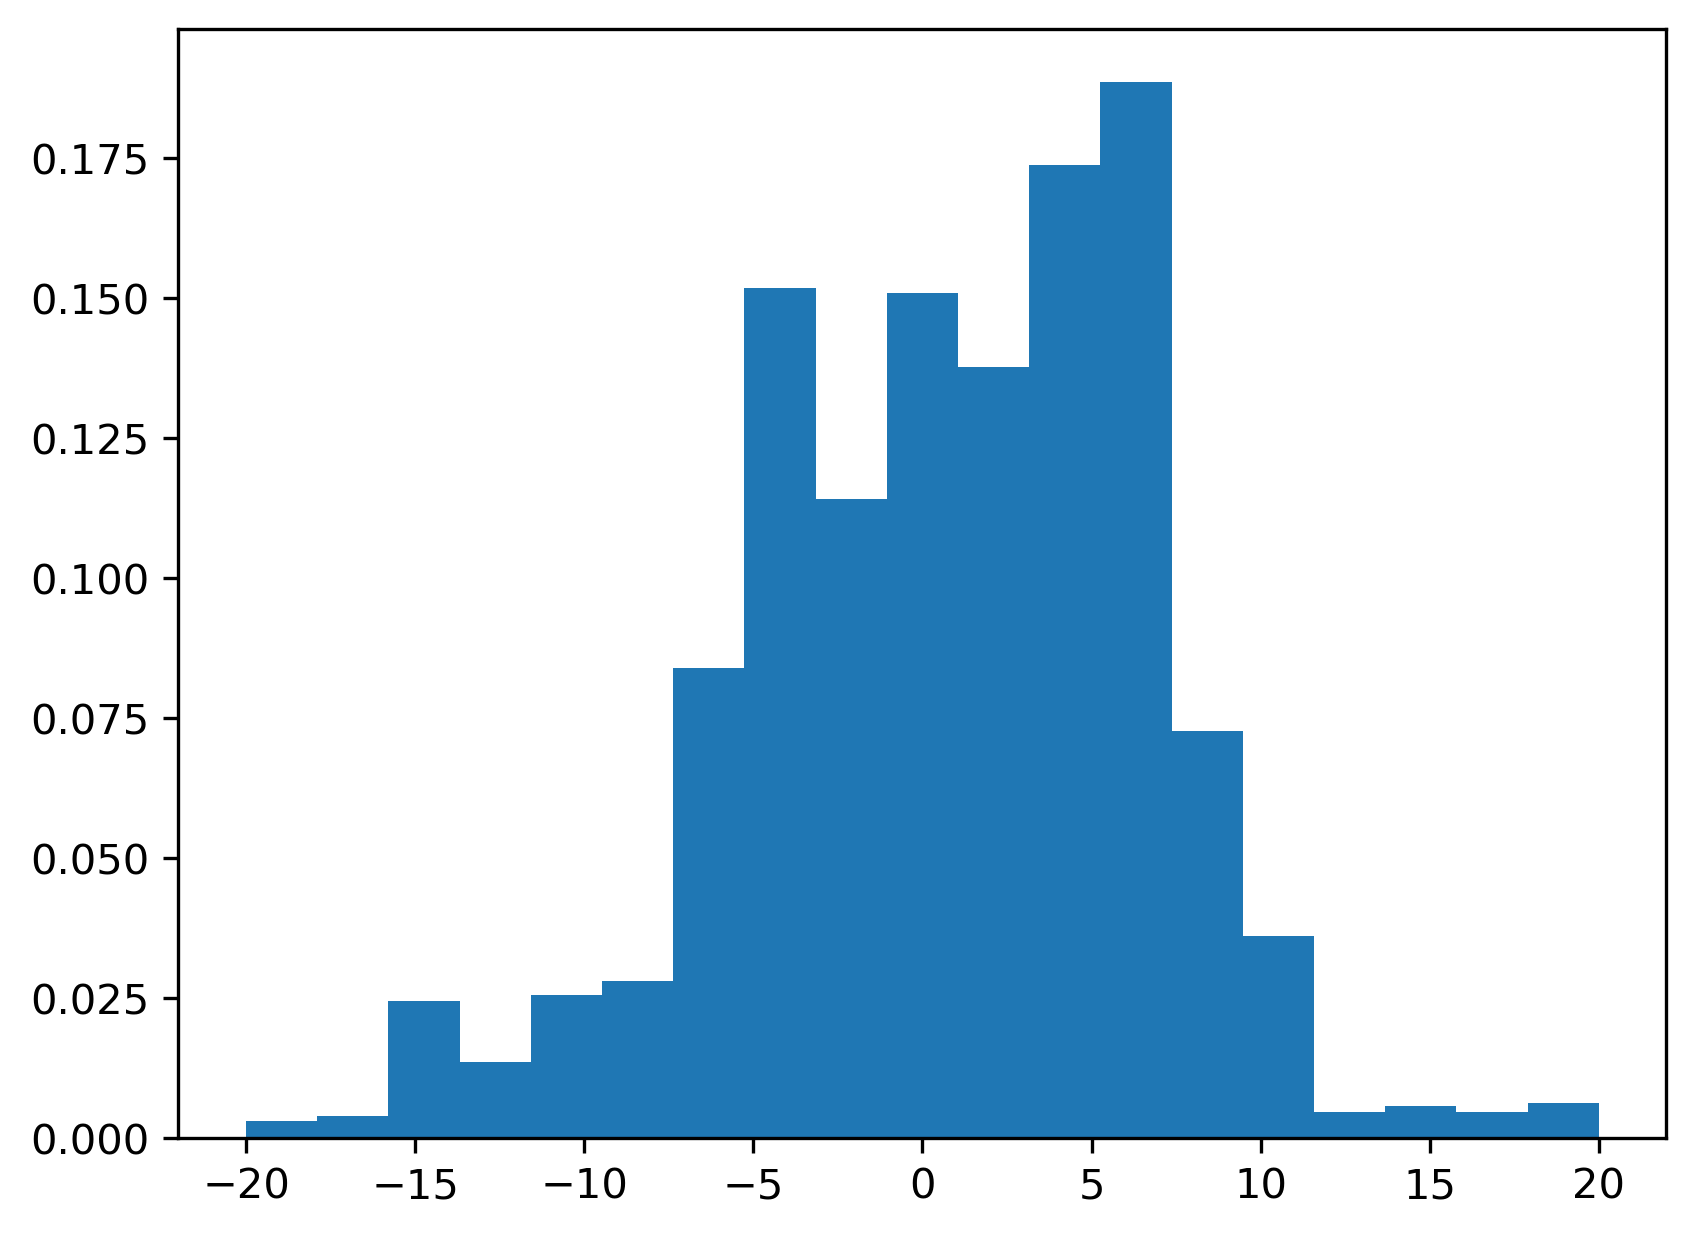

In [73]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize constants outside the loop
lat_bounds = ds['lat_bounds'].data
lon_bounds = ds['lon_bounds'].data
dlat = (3 - 0.5) / 2
dlon = (3 - 0.5) / 2
cp = []

# Create spatial index for catalog_gdf to optimize spatial joins
catalog_gdf.sindex  # Builds the spatial index for faster queries

# r = 200

# for lat_idx in tqdm(range(r)):
#     for lon_idx in range(r):

# Loop through each latitude and longitude bound
for lat_idx in tqdm(range(len(lat_bounds))):
    for lon_idx in range(len(lon_bounds)):
        
        # Extract lat/lon bounds and pad
        lat_min, lat_max = lat_bounds[lat_idx]
        lon_min, lon_max = lon_bounds[lon_idx]
        
        lat_min, lat_max = max(lat_min - dlat, -90), min(lat_max + dlat, 90)
        lon_min, lon_max = lon_min - dlon, lon_max + dlon
        
        # Normalize longitude bounds
        lon_min = (lon_min + 180) % 360 - 180
        lon_max = (lon_max + 180) % 360 - 180
        
        # Define bounding box polygon
        if lon_min <= lon_max:
            bbox = Polygon([
                (lon_min, lat_min), (lon_min, lat_max),
                (lon_max, lat_max), (lon_max, lat_min)
            ])
        else:
            bbox = Polygon([(-180, lat_min), (-180, lat_max), (180, lat_max), (180, lat_min)])
        
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")
        
        # Optimized spatial join with catalog_gdf using precomputed spatial index
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')
        
        # Skip to next iteration if no earthquakes
        if these_earthquakes.empty:
            continue

        # Retrieve load data in batch (vectorized if possible)
        these_loads = ds.isel(lat=lat_idx, lon=lon_idx)['lwe_thickness'].data.flatten()

        # Calculate conditional probabilities
        nt = 205  # per month
        ng = (1 - np.cos((3 * np.pi / 180) / 2)) / 2 * 510e6 / 1e5  # per 100k square km
        LgE = these_earthquakes.dmass
        L = these_loads
        E = len(these_earthquakes) / nt / ng
        
        # Compute P(E|L)
        bins, this_cp = get_cp(LgE, L, 'fd')
        this_cp = this_cp * E
        cp.append(this_cp)

# Average conditional probabilities across all boxes
cp_averaged = np.nanmean(np.array(cp), axis=0)

# Plot the averaged conditional probabilities
wid = np.mean(np.diff(bins))
plt.subplots(dpi=300)
plt.bar(bins[:-1], cp_averaged, width=wid, align='edge')
plt.show()

In [106]:
cp_averaged = np.nanmean(np.array(cp), axis=0)

20
19


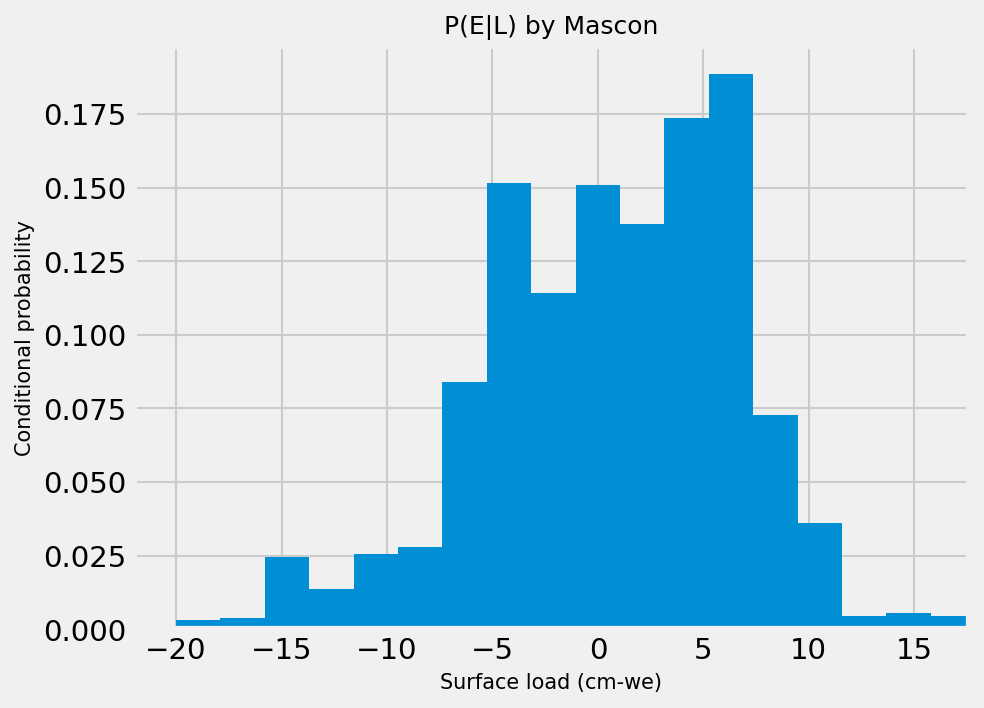

In [120]:
plt.style.use('fivethirtyeight')
wid = np.mean(np.diff(bins))

print(len(bins))
print(len(cp_averaged))

# Create a figure and axis instance
fig, ax = plt.subplots(dpi=150)

# Plot the bar chart
ax.bar(bins[:-1], cp_averaged, width=wid, align='edge')

# Set font size
fs = 10

# Set axis limits and labels
xl = ax.get_xlim()
ax.set_xlim(xl[0], xl[1] - 4.4)
ax.set_xlabel('Surface load (cm-we)', fontsize=fs)
ax.set_ylabel('Conditional probability', fontsize=fs)
ax.set_title('P(E|L) by Mascon', fontsize=fs+2)

# Enable grid
ax.grid(True)

# Show the plot
plt.show()

## Spherical cap version

In [ ]:
# Initialize constants outside the loop
lat_bounds = ds['lat_bounds'].data
lon_bounds = ds['lon_bounds'].data
cap_radius_deg = 1.5  # Spherical cap radius in degrees
cp = []

# Create spatial index for catalog_gdf to optimize spatial joins
catalog_gdf.sindex  # Builds the spatial index for faster queries

# Loop through each handmade mascon based on latitude and longitude bounds
for lat_idx in tqdm(range(len(lat_bounds))):
    for lon_idx in range(len(lon_bounds)):
        
        # Calculate the center point of each mascon based on bounds
        center_lat = (lat_bounds[lat_idx][0] + lat_bounds[lat_idx][1]) / 2
        center_lon = (lon_bounds[lon_idx][0] + lon_bounds[lon_idx][1]) / 2
        
        # Create a Point at the mascon center
        center_point = Point(center_lon, center_lat)
        
        # Create a circular buffer (spherical cap) around the center point
        bbox = center_point.buffer(cap_radius_deg)  # 1.5 degrees spherical cap around center
        
        # Convert the buffer to a GeoDataFrame
        bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs="EPSG:4326")
        
        # Perform spatial join with catalog_gdf to find earthquakes within the cap
        these_earthquakes = gpd.sjoin(catalog_gdf, bbox_gdf, how='inner', predicate='within')
        
        # Skip to the next iteration if no earthquakes are found within this cap
        if these_earthquakes.empty:
            continue
        
        # Retrieve load data for this mascon
        these_loads = ds.isel(lat=lat_idx, lon=lon_idx)['lwe_thickness'].data.flatten()
        
        # Calculate conditional probabilities
        nt = 205  # per month
        ng = (1 - np.cos(cap_radius_deg * np.pi / 180)) / 2 * 510e6 / 1e5  # area per 100k square km
        LgE = these_earthquakes.dmass
        L = these_loads
        E = len(these_earthquakes) / nt / ng
        
        # Compute P(E|L)
        bins, this_cp = get_cp(LgE, L, 'fd')
        this_cp = this_cp * E
        cp.append(this_cp)

# Average conditional probabilities across all mascons
cp_averaged = np.nanmean(np.array(cp), axis=0)

# Plot the averaged conditional probabilities
wid = np.mean(np.diff(bins))
plt.subplots(dpi=300)
plt.bar(bins[:-1], cp_averaged, width=wid, align='edge')
plt.xlabel('Surface Load')
plt.ylabel('Conditional Probability')
plt.title('Conditional Probabilities by Handmade Mascons')
plt.show()

 49%|██████████████████▉                    | 175/360 [1:58:41<28:30,  9.25s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
 49%|███████████████████                    | 176/360 [1:58:50<28:18,  9.23s/it]/Applications/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Appl